# Collab setup

In [ ]:
import torch
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Copy and load the data

In [ ]:
!ls

drive  sample_data


In [ ]:
BASE_PATH = '/content/drive/MyDrive/ai/rsna-brain-tumor/'

In [ ]:
!ls {BASE_PATH}

rsna-brain-tumor  rsna-brain-tumor-data.zip  train_labels.csv


In [ ]:
file = BASE_PATH + 'rsna-brain-tumor-data.zip'

In [ ]:
%%time
!cp {file} .

In [ ]:
!ls

In [ ]:
%%time
!unzip ./rsna-brain-tumor-data.zip -d ./rsna-brain-tumor-data > /dev/null

CPU times: user 761 ms, sys: 136 ms, total: 897 ms
Wall time: 2min 38s


In [ ]:
file = BASE_PATH + 'train_labels.csv'

In [ ]:
%%time
!cp {file} .

CPU times: user 6.44 ms, sys: 4.81 ms, total: 11.2 ms
Wall time: 519 ms


# Imports

In [12]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [13]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import local libs

In [14]:
os.chdir("/content/drive/My Drive/ai/rsna-brain-tumor/rsna-brain-tumor/")
# os.chdir("/content/")

In [60]:
from train import train_num_iter
from utils import get_device, seed_everything

from dataset import Image3DDataset
from model_simple import Simple3DNet

In [16]:
seed = 2021
seed_everything(seed)

# Git repo

In [266]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   dataset.py
	modified:   metrics.py
	modified:   model_simple.py
	modified:   rsna-brain-tumor-train.ipynb
	modified:   train.py

no changes added to commit (use "git add" and/or "git commit -a")


In [268]:
!git diff dataset.py

diff --git a/dataset.py b/dataset.py
index 589c295..b5adc0a 100644
--- a/dataset.py
+++ b/dataset.py
@@ -31,6 +31,13 @@ class Image3DDataset(Dataset):
 
         # name = 'Image-100.png'
         image_names = sorted(os.listdir(images_path), key=lambda name: int(name[6:][:-4]))
+
+        # take slices from the middle
+        image_num = len(image_names)
+        if image_num > self.max_depth:
+            start_index = (image_num - self.max_depth) // 2
+            image_names = image_names[start_index:self.max_depth+start_index]
+
         images = []
         
         for image_name in image_names:
@@ -54,10 +61,19 @@ class Image3DDataset(Dataset):
         D, H, W = image_3d.shape
         # print(D, H, W)
 
-        if D > self.max_depth:
-            image_3d = image_3d[:self.max_depth,:,:]
-        else:
-            image_3d = np.concatenate((image_3d, np.zeros((self.max_depth - D, H, W))), axis=0)
+        # pad with zeros if not not enough images
+        if D < self.max_de

In [ ]:
!git add .

In [ ]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [ ]:
!git commit -m "[collab] use stride=2"

[master 40e28a7] [collab] use stride=2
 3 files changed, 41 insertions(+), 2047 deletions(-)
 rewrite rsna-brain-tumor-train.ipynb (97%)


In [ ]:
!git push origin master

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 133.70 KiB | 9.55 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/MIchaelKa/rsna-brain-tumor.git
   a250cf6..40e28a7  master -> master


# Setup dataset

In [17]:
IMG_SIZE = 256

# TODO add isCollab check
# PATH_TO_DATA = './data/'
PATH_TO_DATA = '/content/'

IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')

In [18]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
train_labels_df.shape

(585, 2)

In [260]:
print(train_labels_df.shape)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 109].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 709].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 123].index)
print(train_labels_df.shape)

(582, 6)
(582, 6)


In [20]:
def row_to_mri_type_count(row, mri_type):
    case_id = row['BraTS21ID']
    case_id = f'{case_id:0>5d}'
    images_path = os.path.join(IMG_PATH_TRAIN, case_id, mri_type)
    try: 
        count = len(os.listdir(images_path))
    except:
        return 0
       
    return count

In [21]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def get_mri_count():
    for mri_type in MRI_TYPES:
        train_labels_df[f'{mri_type}_count'] = train_labels_df.apply(
            lambda row: row_to_mri_type_count(row, mri_type),
            axis=1
        )
        
get_mri_count()

In [22]:
train_labels_df[train_labels_df['FLAIR_count'] == 0]

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count


In [23]:
from plot_utils import show_image_3d

In [24]:
from torchvision import transforms as T

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [224]:
max_depth = 64
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, max_depth, get_train_transform(IMG_SIZE))
len(train_dataset)

582

In [225]:
image, label = train_dataset[2]
type(image), image.shape, label

64 256 256


(numpy.ndarray, (1, 64, 256, 256), 0)

shape: (64, 256, 256)


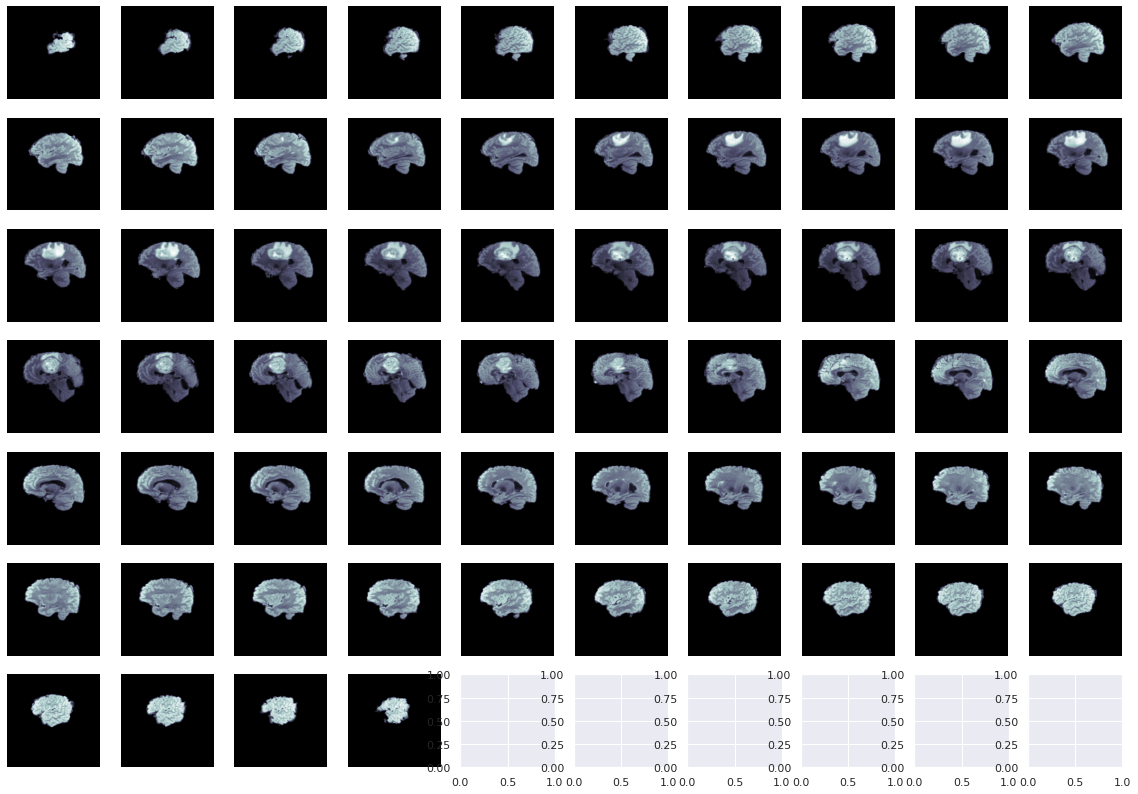

In [226]:
show_image_3d(image)

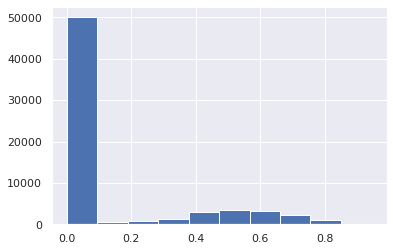

In [28]:
plt.hist(image[0, 40].reshape(-1))
plt.show()

In [29]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
len(train_loader)

146

In [30]:
train_loader_iter = iter(train_loader)

In [31]:
x_batch, y_batch = next(train_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([4, 1, 64, 256, 256]), torch.Size([4]))

In [32]:
x_batch.max()

tensor(1., dtype=torch.float64)

In [33]:
x_batch.dtype, y_batch.dtype

(torch.float64, torch.int64)

In [34]:
x_batch = x_batch.type(torch.float32)

In [35]:
# y_batch = y_batch.long()
# y_batch = y_batch.type(torch.LongTensor)

In [36]:
y_batch, y_batch.dtype

(tensor([0, 1, 0, 1]), torch.int64)

# Profiling

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

In [ ]:
from utils import get_num_of_params

In [ ]:
N, C, D, H, W = 5, 1, 32, 32, 32
X = torch.randn(N, C, D, H, W)

In [ ]:
model = Simple3DNet()

In [ ]:
get_num_of_params(model)

1107905

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(X)

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         1.18%       2.844ms        99.98%     241.917ms     241.917ms             1  
                     aten::conv3d         0.02%      37.000us        64.56%     156.219ms      52.073ms             3  
                aten::convolution         0.01%      34.000us        64.55%     156.182ms      52.061ms             3  
               aten::_convolution         0.03%      68.000us        64.54%     156.148ms      52.049ms             3  
         aten::mkldnn_convolution        64.35%     155.709ms        64.51%     156.080ms      52.027ms             3  
                 aten::max_pool3d       

In [ ]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         3.03%      13.457ms        99.99%     443.455ms     443.455ms             1                                                                                []  
                     aten::conv3d         0.01%      25.000us        39.04%     173.136ms     173.136ms             1                        [[5, 1, 32, 32, 32], [64, 1, 3, 3, 3], [], [], [], 

In [ ]:
# model = Simple3DNet().to(device)
# X = torch.randn(N, C, D, H, W).to(device)

model = Simple3DNet()
X = torch.randn(N, C, D, H, W)

In [ ]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(X)

In [ ]:
# cpu_memory_usage

# cuda_time_total

print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::clamp_min         5.34%      12.196ms        10.67%      24.356ms       4.059ms     105.00 Mb      52.50 Mb             6  
                      aten::empty         0.05%     116.000us         0.05%     116.000us       7.733us      52.50 Mb      52.50 Mb            15  
                     aten::conv3d         0.01%      29.000us        63.12%     144.145ms      48.048ms      52.50 Mb           0 b             3  
                aten::convolution         0.01%      32.000us        63.11%     144.116ms      48.039ms      52.

# Memory management

In [37]:
def display_memory():
    torch.cuda.empty_cache()
    memory = torch.cuda.memory_allocated(device)
    print("{:.3f} GB".format(memory / 1024 ** 3))

In [ ]:
display_memory()
X = torch.randn(4, 1, 64, 256, 256).to(device)
display_memory() # 256*256*256*4 / 1024 ** 3

0.038 GB
0.069 GB


In [ ]:
%%time

display_memory()

model = Simple3DNet().to(device)
output = model(X)
print(output.shape)

display_memory()
del output
display_memory()

0.069 GB
torch.Size([4, 1])
3.874 GB
0.069 GB
CPU times: user 84.6 ms, sys: 502 ms, total: 587 ms
Wall time: 6.44 s


In [ ]:
# when we can do this during training?
# we do not need actually?
# del output

# Single model path

In [ ]:
model = Simple3DNet()

In [ ]:
%%time
N, C, D, H, W = 5, 1, 26, 256, 256
X = torch.randn(N, C, D, H, W)

output = model(X)
output.shape

CPU times: user 30.1 s, sys: 5.37 s, total: 35.5 s
Wall time: 34.9 s


torch.Size([5, 1])

In [ ]:
# del output

In [ ]:
%%time
output = model(x_batch)
output.shape

CPU times: user 21.5 s, sys: 1.84 s, total: 23.4 s
Wall time: 23.4 s


In [ ]:
output.shape

torch.Size([4, 1])

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# output.dtype, y_batch.dtype

In [ ]:
y_batch = y_batch.type_as(output)
loss = criterion(output.squeeze(1), y_batch)

In [ ]:
loss

tensor(0.6934, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [ ]:
output, y_batch

(tensor([[0.0432],
         [0.0432],
         [0.0433],
         [0.0432]], grad_fn=<AddmmBackward>), tensor([0., 1., 0., 1.]))

In [ ]:
output.shape, y_batch.shape

(torch.Size([4, 1]), torch.Size([4]))

In [ ]:
y_pred = (output.squeeze(1) > 0)
# y_pred = torch.sigmoid(output)
# y_pred = y_pred > 0.5
y_pred, y_pred.shape

(tensor([True, True, True, True]), torch.Size([4]))

In [ ]:
correct_samples = torch.sum(y_pred == y_batch)
correct_samples

tensor(2)

In [ ]:
y_batch.shape[0]

4

# Overfit small dataset

In [228]:
display_memory()

0.062 GB


In [229]:
train_number = 32

train_df_0 = train_labels_df[
    (train_labels_df['FLAIR_count'] < 75) &
    (train_labels_df['FLAIR_count'] > 60) &
    (train_labels_df['MGMT_value'] == 0)]

train_df_0 = train_df_0.sample(frac=1).head(train_number//2)

train_df_1 = train_labels_df[
    (train_labels_df['FLAIR_count'] < 75) &
    (train_labels_df['FLAIR_count'] > 60) &
    (train_labels_df['MGMT_value'] == 1)]

train_df_1 = train_df_1.sample(frac=1).head(train_number//2)

train_df = pd.concat([train_df_0, train_df_1]).sample(frac=1).reset_index(drop=True)
train_df.head()

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,17,0,74,28,231,87
1,54,1,72,27,240,82
2,6,1,68,28,89,270
3,98,1,73,30,249,73
4,53,0,74,29,243,300


In [230]:
max_depth = 64
train_dataset = Image3DDataset(train_df, IMG_PATH_TRAIN, max_depth, get_train_transform(IMG_SIZE))
len(train_dataset)

29

In [231]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
len(train_loader)

8

In [128]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [249]:
max_iter = 400
print_every = 10

seed_everything(seed)

model = Simple3DNet().to(device)

learning_rate = 0.001
weight_decay = 0

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
#     weight_decay=weight_decay,
# )

loss_meter, score_meter = train_num_iter(
    model, device, train_loader, criterion, optimizer,
    max_iter=max_iter,
    print_every=print_every
)

[train] iter:    0, loss = 0.69934, score = 0.25000, time: 0:00:01
[train] iter:   10, loss = 0.73637, score = 0.53659, time: 0:00:09
[train] iter:   20, loss = 0.71163, score = 0.52564, time: 0:00:17
[train] iter:   30, loss = 0.71206, score = 0.52174, time: 0:00:25
[train] iter:   40, loss = 0.69686, score = 0.54362, time: 0:00:32
[train] iter:   50, loss = 0.67911, score = 0.58602, time: 0:00:40
[train] iter:   60, loss = 0.66863, score = 0.58744, time: 0:00:48
[train] iter:   70, loss = 0.66652, score = 0.58846, time: 0:00:56
[train] iter:   80, loss = 0.65842, score = 0.59184, time: 0:01:03
[train] iter:   90, loss = 0.64429, score = 0.60725, time: 0:01:11
[train] iter:  100, loss = 0.64622, score = 0.61141, time: 0:01:19
[train] iter:  110, loss = 0.64474, score = 0.61975, time: 0:01:27
[train] iter:  120, loss = 0.64477, score = 0.63098, time: 0:01:35
[train] iter:  130, loss = 0.63850, score = 0.63866, time: 0:01:43
[train] iter:  140, loss = 0.63038, score = 0.64522, time: 0:0

In [250]:
model

Simple3DNet(
  (backbone): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU()
    (8): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=262144, out_features=1, bias=True)
)

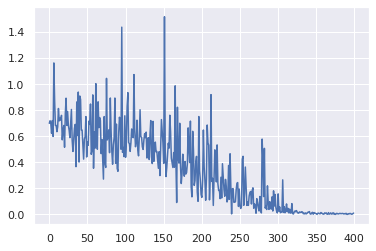

In [251]:
plt.plot(loss_meter.history)

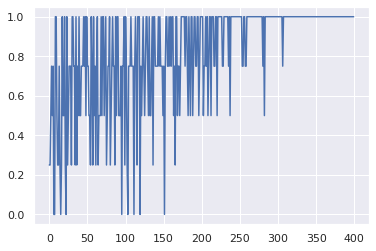

In [252]:
plt.plot(score_meter.history)

In [80]:
# score_meter.predictions
# score_meter.outputs
# score_meter.ground_truth

In [78]:
# score_meter.get_predictions()
# score_meter.get_outputs()
# score_meter.get_ground_truth()

In [155]:
score_meter.get_ground_truth()[-last_n:]

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1.], dtype=float32)

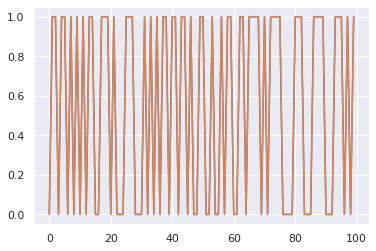

In [171]:
# plt.plot(score_meter.get_ground_truth())
# plt.plot(score_meter.get_predictions())

last_n = 100
plt.plot(score_meter.get_ground_truth()[-last_n:])
plt.plot(score_meter.get_predictions()[-last_n:])

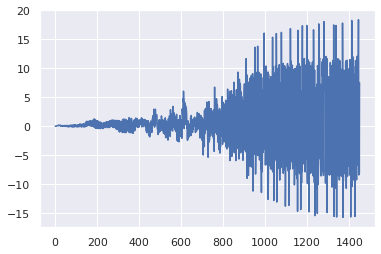

In [172]:
plt.plot(score_meter.get_outputs())

# Train

In [253]:
from sklearn.model_selection import train_test_split

In [261]:
train_df, valid_df = train_test_split(train_labels_df, test_size=0.2)
print(f'Dataframe size, train: {len(train_df)}, valid: {len(valid_df)}')

Dataframe size, train: 465, valid: 117


In [262]:
train_df

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
169,250,1,49,150,150,47
2,3,0,71,28,88,285
573,998,1,28,28,28,28
263,386,1,48,158,157,47
354,523,1,148,223,69,124
...,...,...,...,...,...,...
44,68,1,279,26,67,84
130,195,0,47,140,140,47
57,90,0,148,28,235,279
343,507,0,146,27,88,68


In [263]:
max_depth = 64
train_dataset = Image3DDataset(train_df, IMG_PATH_TRAIN, max_depth, get_train_transform(IMG_SIZE))
valid_dataset = Image3DDataset(valid_df, IMG_PATH_TRAIN, max_depth, get_train_transform(IMG_SIZE))
len(train_dataset), len(valid_dataset)

(465, 117)

In [264]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)
len(train_loader), len(valid_loader)

(117, 30)

In [265]:
max_iter = 400
print_every = 10

seed_everything(seed)

model = Simple3DNet().to(device)

learning_rate = 0.001
weight_decay = 0

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=learning_rate,
#     weight_decay=weight_decay,
# )

loss_meter, score_meter = train_num_iter(
    model, device, train_loader, criterion, optimizer,
    max_iter=max_iter,
    print_every=print_every
)

[train] iter:    0, loss = 0.69693, score = 0.00000, time: 0:00:01


KeyError: ignored